In [10]:
import os
#import random
#import pandas as pd
import numpy as np
#import glob
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
#%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
import cv2

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam

from keras_unet_collection import models #Keras unet collection
from keras import utils
#import tensorflow as tf
from PIL import Image
from datetime import datetime

In [11]:
import os
import random
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets
import cv2

import tensorflow as tf

from keras.backend import clear_session
from keras import backend as K
from keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16 
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## DL Swin without k-fold

In [13]:
import numpy as np
from glob import glob
import sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate
from tensorflow.keras.utils import to_categorical

In [7]:
# the indicator of a fresh run
first_time_running = True

# user-specified working directory
filepath = 'D:/UniBas/Bachelorarbeit/'

if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'some_images/'
    filename_target = filepath+'some_masks/'

def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)

sample_names = np.array(sorted(glob(filepath+'.tif')))
label_names = np.array(sorted(glob(filepath+'.tif')))

L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

AttributeError: module 'tensorflow.keras.utils' has no attribute 'shuffle_ind'

In [26]:
#define directory where images and masks are located on local disk
image_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images/'
mask_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_masks_RF/insert_masks/'
#'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_masks_RF/insert_masks/'

#define the properties and empty list for resized images and masks
SIZE = 256
image_dataset = []
mask_dataset = []


#define custom functions
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

#enumerate and resize images/masks
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#define some hyperparameters
num_labels = 2  #Binary classificaion (missmatch with literature/code examples!)
batch_size = 2  #keep it smaller than 3
epochs = 2


#normalize images
image_dataset = np.array(image_dataset)/255
#do not normalize masks, just rescale to 0 to 1. Add RGB-Chanel (3) to mask.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255
mask_dataset = tf.keras.utils.to_categorical(mask_dataset)

""" plt.imshow(mask_dataset[1])
plt.show()
plt.imshow(image_dataset[1])
plt.show() """

print(image_dataset[1].shape)
print(mask_dataset[1].shape)

#define callback function
callbacks = [
  EarlyStopping(patience=8, verbose=1),
  ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
  ModelCheckpoint('A_modelSwinV1.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
  CSVLogger('A_modelSwinV1.csv', separator=',', append=False)]
    
#define the model architecture
#this model requires depth >= 2
model = models.swin_unet_2d((256, 256, 3), filter_num_begin=64, n_labels=num_labels, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(4, 4), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Softmax', shift_window=True, name='swin_unet') #Guess: Shift_window = False

#compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
            metrics=['accuracy', IoU])

#split dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#start time meauserment
start2 = datetime.now() 

#fit model to data
resunet_history = model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

#stop time measurement and print the execution time
stop2 = datetime.now() 
execution_time = stop2-start2
print("R2-Unet fitting time is: ", execution_time)

(256, 256, 3)
(256, 256, 2)
Epoch 1/2
230/230 [==============================] - 365s 2s/step - loss: 0.1966 - accuracy: 0.9209 - IoU: 0.9253 - val_loss: 0.0586 - val_accuracy: 0.9774 - val_IoU: 0.9667

Epoch 00001: val_loss improved from inf to 0.05858, saving model to A_modelSwinV1.h5
Epoch 2/2
230/230 [==============================] - 338s 1s/step - loss: 0.0653 - accuracy: 0.9736 - IoU: 0.9694 - val_loss: 0.0498 - val_accuracy: 0.9800 - val_IoU: 0.9740

Epoch 00002: val_loss improved from 0.05858 to 0.04975, saving model to A_modelSwinV1.h5
R2-Unet fitting time is:  0:11:59.499520


TypeError: Invalid shape (256, 256, 1, 1) for image data

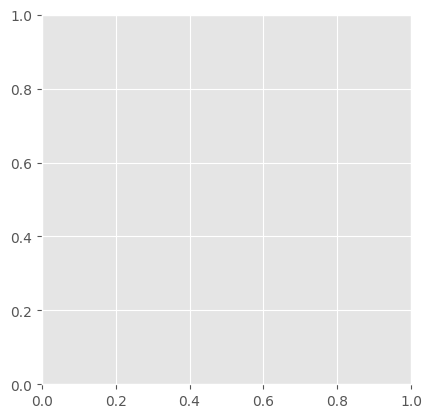

In [33]:
image_dataset = []
for path in glob.glob('D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images/'):
    for img_path in glob.glob(os.path.join(path, "*.tif")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (256,256))
        img = img_to_array(img)
        img = img/255.0
        image_dataset.append(img)  
image_dataset = np.array(image_dataset)

mask_dataset = []
for path in glob.glob('D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_masks_RF/insert_masks/'):
    for mask_path in glob.glob(os.path.join(path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256,256))
        mask = img_to_array(mask)
        mask = mask/255.0
        mask_dataset.append(mask)
        
mask_dataset = np.array(mask_dataset)
mask_dataset = np.expand_dims(mask_dataset, axis=3)

plt.imshow(mask_dataset[1])
plt.show()
plt.imshow(image_dataset[1])
plt.show()

## DL Swin with k-Fold 

In [5]:
#define directory where images and masks are located on local disk
image_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images'
mask_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_masks/'

#define the properties and empty list for resized images and masks
SIZE = 256
image_dataset = []
mask_dataset = []

#define custom functions
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

#enumerate and resize images/masks
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

#define some hyperparameters
num_labels = 1  #Binary classificaion (missmatch on coding examples! 1 or 2 for binary classification)
batch_size = 2  #keep it smaller than 3
epochs = 60
num_folds = 5   #define the number of folds (usually 5-10 folds)

#normalize images
image_dataset = np.array(image_dataset)/255.
#do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

#define K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

#define per-fold score containers 
acc_per_fold = []
loss_per_fold = []
IoU_per_fold = []

#K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'K-foldno{fold_no}-swinunet-V1-VL-256.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'K-foldno{fold_no}-swinunet-V1-VL-256.csv', separator=',', append=False)]
  
  #define the model architecture
  #this model requires depth >= 2
  model = models.swin_unet_2d((256, 256, 3), filter_num_begin=64, n_labels=num_labels, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Softmax', shift_window=False, name='swin_unet') #Guess: Shift_window = False

  #compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model on data
  swin_unet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]} - IoU: {IoU_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> IoU: {np.mean(IoU_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
16/16 [==============================] - 56s 3s/step - loss: 1.1253 - accuracy: 0.4944 - IoU: 0.5445 - val_loss: 0.7210 - val_accuracy: 0.4984 - val_IoU: 0.5465

Epoch 00001: val_loss improved from inf to 0.72103, saving model to K-foldno1-swinunet-V1-VL-256.h5
1/1 [==============================] - 6s 6s/step - loss: 0.7210 - accuracy: 0.4984 - IoU: 0.5465
------------------------------------------------------------------------
Training for fold 2 ...
16/16 [==============================] - 62s 3s/step - loss: 1.0039 - accuracy: 0.5070 - IoU: 0.5480 - val_loss: 0.7046 - val_accuracy: 0.5332 - val_IoU: 0.5431

Epoch 00001: val_loss improved from inf to 0.70462, saving model to K-foldno2-swinunet-V1-VL-256.h5
1/1 [==============================] - 7s 7s/step - loss: 0.7046 - accuracy: 0.5332 - IoU: 0.5431
------------------------------------------------------------------------
Score per fol